<a href="https://colab.research.google.com/github/Atrib99/ProgrammingAssignment2/blob/master/Bayesian_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import datasets
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [2]:
# Load the Iris dataset for demonstration
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [3]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Initialize the Gaussian Naive Bayes classifier
gnb = GaussianNB()


In [5]:
# Fit the model to the training data
gnb.fit(X_train, y_train)


GaussianNB()

In [7]:
# Make predictions on the test set
y_pred = gnb.predict(X_test)

In [8]:
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 1.00


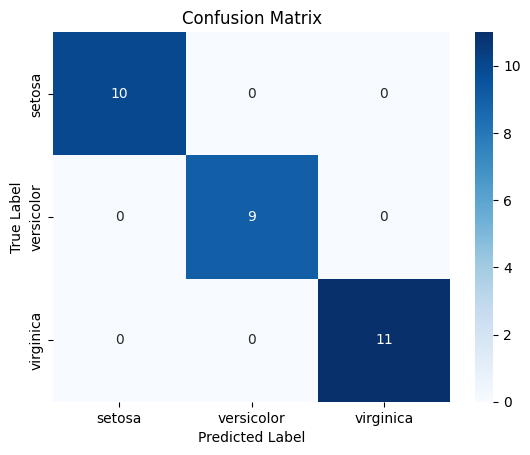

In [9]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()